<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Comparision-of-Bedmap2-and-Bedmachine" data-toc-modified-id="Comparision-of-Bedmap2-and-Bedmachine-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparision of Bedmap2 and Bedmachine</a></span><ul class="toc-item"><li><span><a href="#How-to-run-it" data-toc-modified-id="How-to-run-it-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>How to run it</a></span></li><li><span><a href="#Flowline" data-toc-modified-id="Flowline-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Flowline</a></span></li><li><span><a href="#Shelf-extension" data-toc-modified-id="Shelf-extension-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Shelf extension</a></span></li></ul></li></ul></div>

# Comparision of Bedmap2 and Bedmachine

link to shelf extension : [Shelf-extension](#Shelf-extension)

## How to run it
you need to download bedmap2 (https://secure.antarctica.ac.uk/data/bedmap2/), bedmachine (https://nsidc.org/data/nsidc-0756) and the grounding line (https://nsidc.org/data/NSIDC-0498/versions/2)

You can also used the flowline that I done. Or do yours with paraview and the velocity field (https://nsidc.org/data/NSIDC-0484/versions/2)

In [1]:
import numpy as np
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import griddata
from matplotlib.colors import SymLogNorm
from matplotlib import cm
import geopandas as gpd
import seaborn as sns
import pyvista as pv
from matplotlib.colors import LogNorm
from scipy import ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
# %matplotlib notebook

size=40
params = {'legend.fontsize': 'xx-large',
          'figure.titlesize':'xx-large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

The following cell contains functions used.

**stat** : compute the mean, the median, 25% and 75% quantile. It need the dataset

**selectarea** is used to select the arrea. It need 4 arguments. values is the limit of the area [xmin xmax ymin ymax]. X and y are the original coordinates. variable is the dataset.

**figure** is a function made to create a pcolormesh plot with a log normalization of the colorbar. Arguments: x and y are the coordinate. Z the dataset. titlevariable is the the a string describing the input variable ex: "Bedrock". param are the parameter of the symlog normalization.

**line_flow** determine the values along a flow_line. It need to input a csv containing the coordinate of the line. The function is defined to use colunm 22 and 23. This depend of your data. flowline is the name of the file without extension. x and y are the coordinate of the data. z_bed1 and z_bed2 are the 2 dataset.

In [2]:
def stat(x):
    mean=np.nanmean(x)
    median=np.nanquantile(x,0.5)
    quartile1=np.nanquantile(x,0.25)
    quartile3=np.nanquantile(x,0.75)
    std=np.nanstd(x)
    return mean,median,quartile1,quartile3,std

def selectarea(values,x,y,variable):
    xx=x[int(np.where(x==values[0])[0]):int(np.where(x==values[1])[0])]
    yy=y[int(np.where(y==values[2])[0]):int(np.where(y==values[3])[0])]
    variable_set=variable[int(np.where(y==values[2])[0]):int(np.where(y==values[3])[0]),int(np.where(x==values[0])[0]):int(np.where(x==values[1])[0])]
    return xx,yy,variable_set

def figures(x,y,z,sf,titlevariable,colorbartitle,param):
    stati=stat(z)
    fig=plt.figure(figsize=[20,12])
    plt.rcParams.update({'font.size': 15})
    ax=plt.gca()
    sf.plot(ax=ax, color='k')
    im=plt.pcolormesh(x,y,z,norm=SymLogNorm(linthresh=param[0], linscale=param[1] , vmin=param[2], vmax=param[3]),cmap=cm.seismic)
    cbar=plt.colorbar(im)
    plt.xlim(x.min(),x.max())
    plt.ylim(y.min(),y.max())
    cbar.set_label(colorbartitle)
    plt.title(titlevariable + 'Bedmap2-bedmachine \n  mean=' + str(stati[0]) + ' median=' +str(stati[1]) + ' quartile 25%=' +str(stati[2]) +'\n quartile 75%=' +str(stati[3]) + ' std=' +str(stati[4]))
    #fig.savefig(titlevariable + '.png')
    plt.show()
    #plt.close('all')
    #fig1=plt.figure(figsize=[20,12])
    #plt.rcParams.update({'font.size': 15})
    #sns.boxplot(z)
    #plt.close('all')

def line_flow(flowline,x,y,z_bed1,z_bed2):
    #interpolate from line
    x_fl,y_fl=np.loadtxt(flowline + '.csv',skiprows=1,delimiter=',',usecols=(22,23),unpack=True) 
    x_temp=(x_fl-x.min())/1000
    y_temp=(y_fl-y.min())/1000
    # profil along line interpolated
    f_bed1 = ndimage.map_coordinates(np.array(z_bed1),[y_temp,x_temp],mode='nearest', order=1)
    f_bed2 = ndimage.map_coordinates(np.array(z_bed2),[y_temp,x_temp],mode='nearest', order=1)
    dist=np.zeros(len(x_fl))
    for i in range(0,len(x_fl)-1):
        dist[i+1]=dist[i]+np.sqrt((x_fl[i]-x_fl[i+1])**2+(y_fl[i]-y_fl[i+1])**2)
    return x_fl,y_fl,f_bed1,f_bed2,dist

# DISCLAIMER: This function is copied from https://github.com/nwhitehead/swmixer/blob/master/swmixer.py, 
#             which was released under LGPL. 
def resample_by_interpolation(signal, input_fs, output_fs):

    scale = output_fs / input_fs
    # calculate new length of sample
    n = round(len(signal) * scale)

    # use linear interpolation
    # endpoint keyword means than linspace doesn't go all the way to 1.0
    # If it did, there are some off-by-one errors
    # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
    # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
    # Both are OK, but since resampling will often involve
    # exact ratios (i.e. for 44100 to 22050 or vice versa)
    # using endpoint=False gets less noise in the resampled sound
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    return resampled_signal


We define and load the data.

First the position to crops some areas.

Then, the bed depth and the ice thickness from bedmap2 and bedmachine. We resample bedmachine to have the same step as bedmap2 and we translate the '-9999' to Nan.

We compute the ratio between the two beds : $ratio=\frac{bedmap}{bedmachine}-1$

In [3]:
import rasterio
from rasterio.plot import show
surface = rasterio.open(
    '/home/urrutyb/Documents/PhD_TiPACCS/data_antarctica/bedmap2_tiff/bedmap2_surface.tif')
thickness = rasterio.open(
    '/home/urrutyb/Documents/PhD_TiPACCS/data_antarctica/bedmap2_tiff/bedmap2_thickness.tif')
bedmap = rasterio.open(
    '/home/urrutyb/Documents/PhD_TiPACCS/data_antarctica/bedmap2_tiff/bedmap2_bed.tif')

bedmap_bed = np.flip(bedmap.read(1,), 0)
bedmap_th = np.flip(thickness.read(1,), 0)
bedmap_surf = np.flip(surface.read(1,), 0)

del bedmap, thickness, surface

In [4]:
#chargement des données
sf = gpd.read_file("/home/urrutyb/Documents/PhD_TiPACCS/data_antarctica/InSAR_GL_Antarctica_v02/InSAR_GL_Antarctica_v02.shp")
sf=sf.to_crs({'init':'epsg:3031'})
bedmachine=xr.load_dataset("/home/urrutyb/Documents/PhD_TiPACCS/data_antarctica/BedMachineAntarctica_2019-11-05_v01MODIFIED.nc")


#selection des données
index=np.arange(0,len(bedmachine.x),2)
bedmachinebed=np.flip(bedmachine.bed[index,index],0)
bedmachineth=np.flip(bedmachine.thickness[index,index],0)
bedmachinesurf=np.flip(bedmachine.surface[index,index],0)
bedmachinemask=np.flip(bedmachine.mask[index,index],0)
source=np.flip(bedmachine.source[index,index],0)

x=np.array(bedmachinemask.x)
y=np.array(bedmachinemask.y)
# bedmap_bed[bedmap_bed==-9999]=np.nan
# bedmap_th[bedmap_th==-9999]=np.nan

test=bedmap_bed-bedmachinebed
rap=np.abs(bedmap_bed/np.array(bedmachinebed))-1
thick_diff=bedmap_th-bedmachineth
thick_ra=bedmap_th/bedmachineth-1



/home/urrutyb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/urrutyb/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)
/home/urrutyb/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: overflow encountered in true_divide
  result_data = func(*input_data)
/home/urrutyb/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: invalid value encountered in true_divide
  result_data = func(*input_data)


In [5]:
print(source)
del(bedmachine)


<xarray.DataArray 'source' (y: 6667, x: 6667)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)
Coordinates:
  * x        (x) int32 -3333000 -3332000 -3331000 ... 3331000 3332000 3333000
  * y        (y) int32 -3333000 -3332000 -3331000 ... 3331000 3332000 3333000
Attributes:
    long_name:      data source
    grid_mapping:   mapping
    valid_range:    [ 1 10]
    flag_values:    [ 1  2  3  4  5  6  7 10]
    flag_meanings:  REMA_IBCSO mass_conservation interpolation hydrostatic st...
    source:         Mathieu Morlighem


The figures to compare the whole antarctica. **Pretty long to run!!!!!!!!!**

In [6]:
#figure all antarctica
# figures(x,y,test,sf,'Bedrock ','différence of bedrock (meter)',[10,0.1,test.min(),test.max()])
# figure(x,y,rap,sf,'Bedrock ratio ','ratio (bedmap/bedmachine-1)',[0.1,0.1,-10,10])
# figure(x,y,thick_diff,sf,'Thickness ','différence of thickness (meter)',[10,0.1,thick_diff.min(),thick_diff.max()])
# figure(x,y,thick_ra,sf,'Thickness ratio ','ratio (bedmap/bedmachine-1)',[0.1,0.1,-10,10])

We are selecting some areas. At the beginning I decide to remove half of the data from bedmachine to have the same mesh as bedmap. Now I will compare them by a way that I can compare with different distance step.

In [7]:
# #Select Ronne
# x_Ronne,y_Ronne,z_Ronne=selectarea(Ronne,x,y,test)
# figure(x_Ronne,y_Ronne,z_Ronne,sf,'Bedrock Ronne ','différence of bedrock (meter)',[10,0.1,z_Ronne.min(),z_Ronne.max()])

# #Select Amundsen

# x_Amundsen,y_Amundsen,z_bedmap=selectarea(Amundsen,x,y,bedmap_bed)
# x_Amundsen,y_Amundsen,z_bedmachine=selectarea(Amundsen,x,y,bedmachinebed)
# testbis=np.flip(bedmachine.bed,0)
# x_Amundsen2,y_Amundsen2,z_bedmachine2=selectarea(Amundsen,testbis.x,testbis.y,testbis)
# x_Amundsen,y_Amundsen,z_bed=selectarea(Amundsen,x,y,test)
# figure(x_Amundsen,y_Amundsen,z_bed,sf,'Bedrock Amunsen ','différence of bedrock (meter)',[10,0.1,z_bed.min(),z_bed.max()])


## Flowline

Figures showing the data at the flowline. The loop is working on all the file call "flow_line" with csv extension.

10269


12467


4329


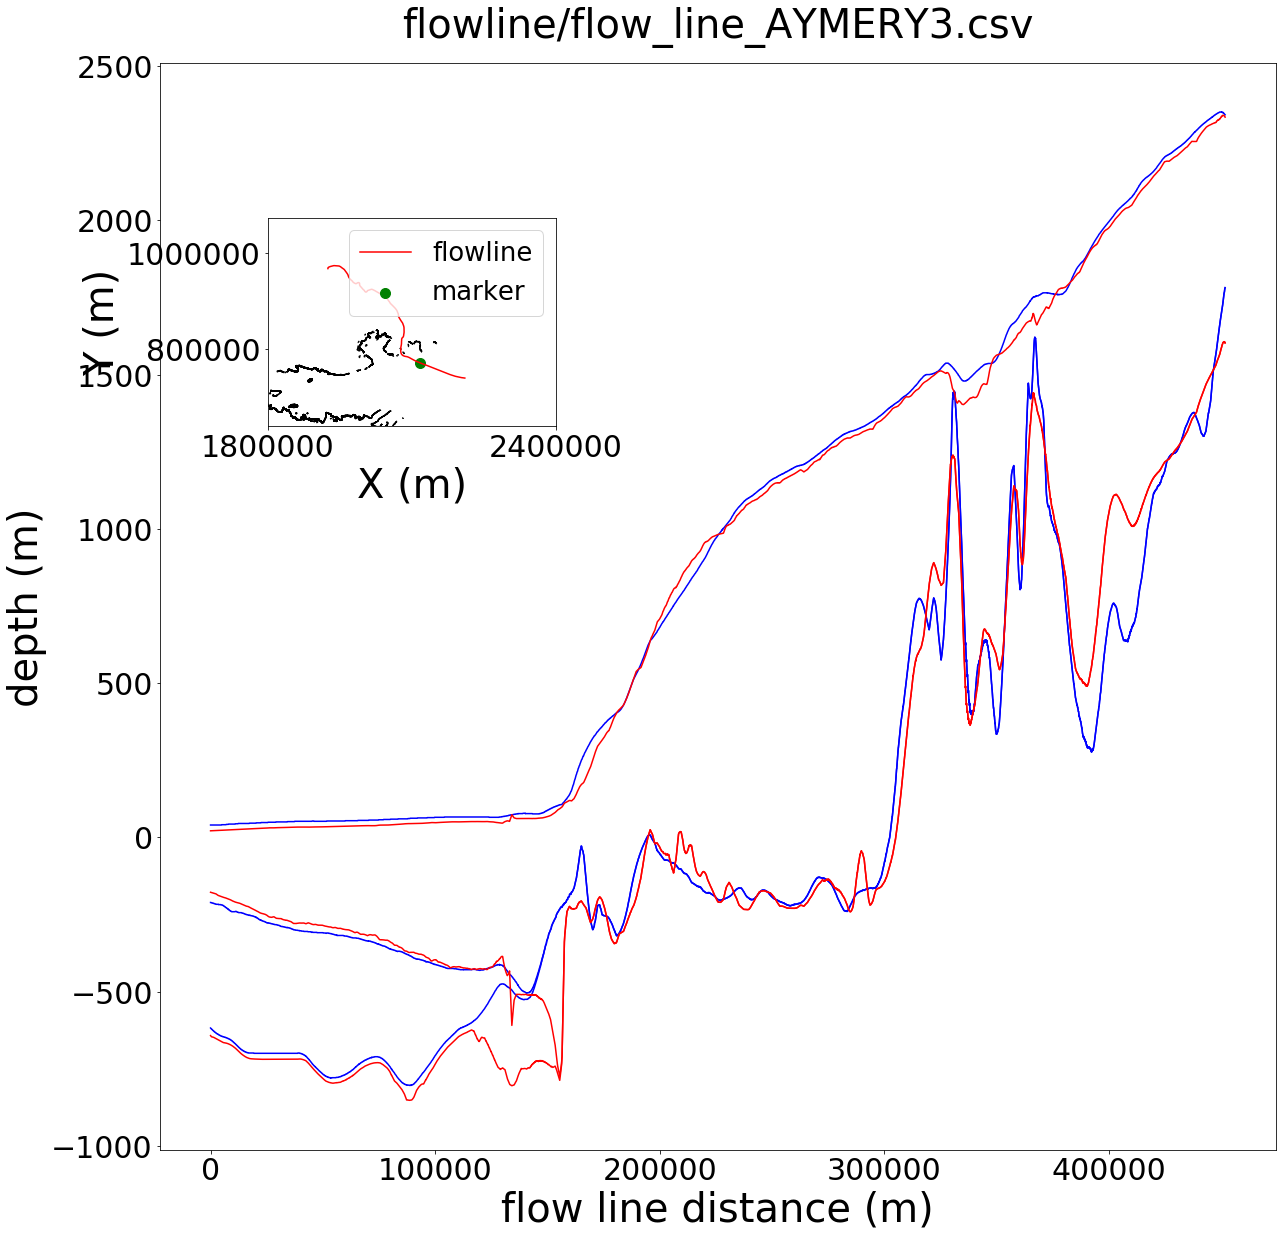

7452


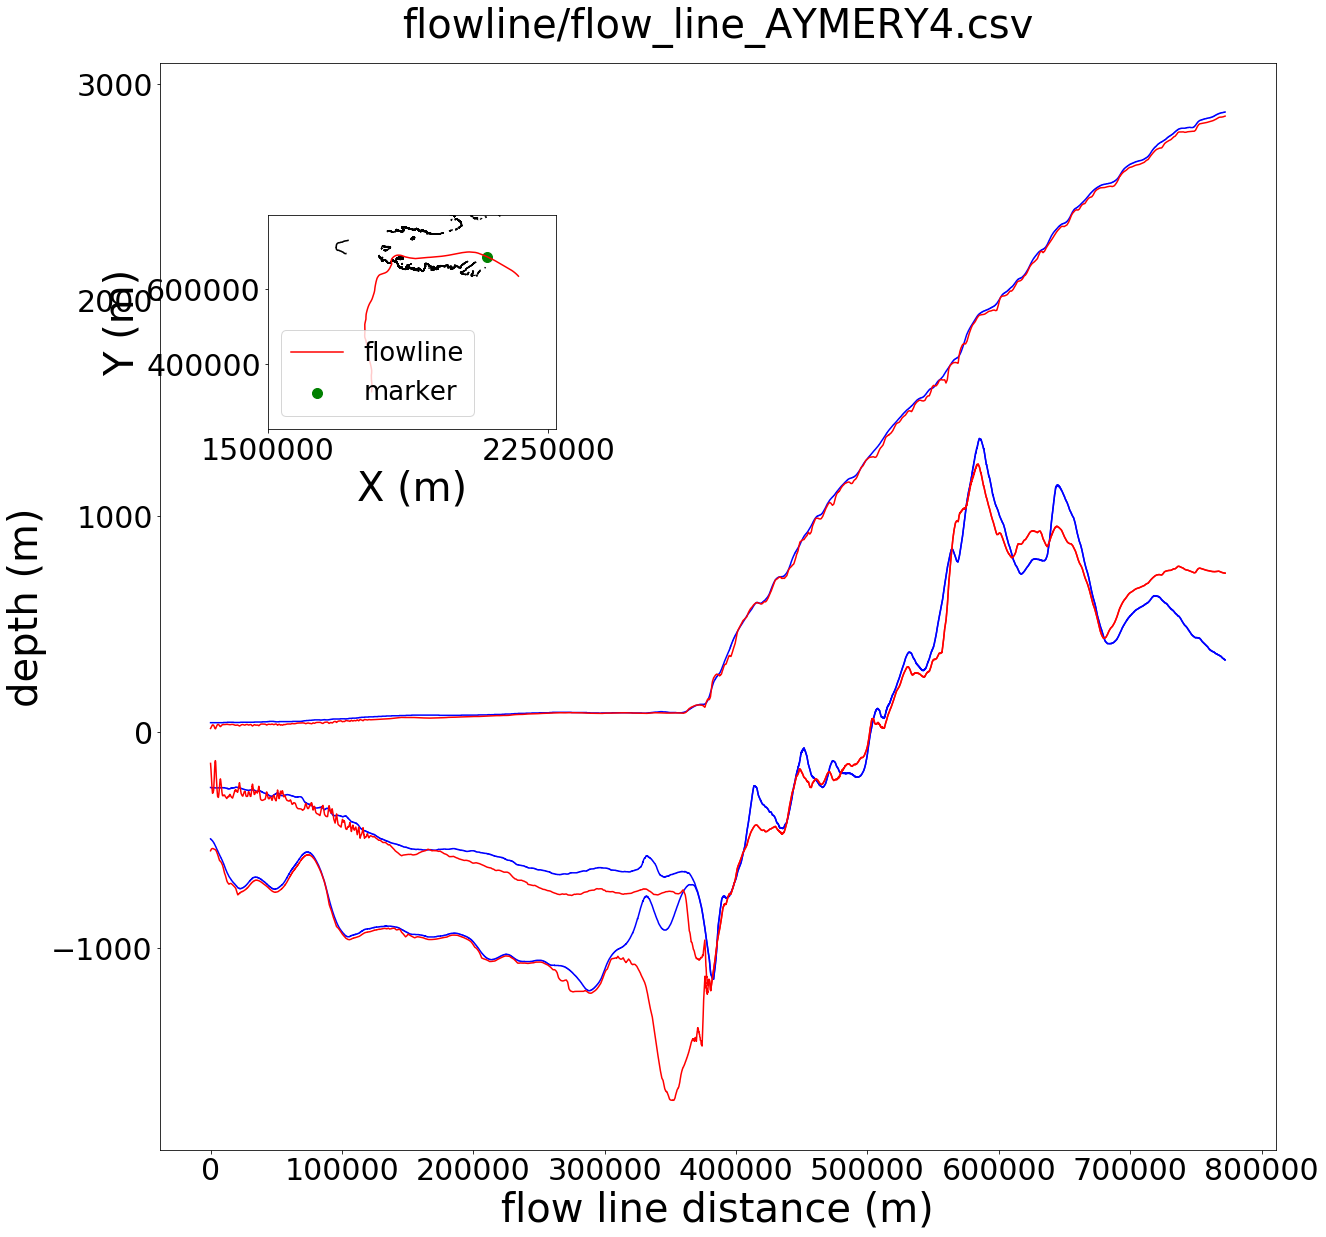

3594


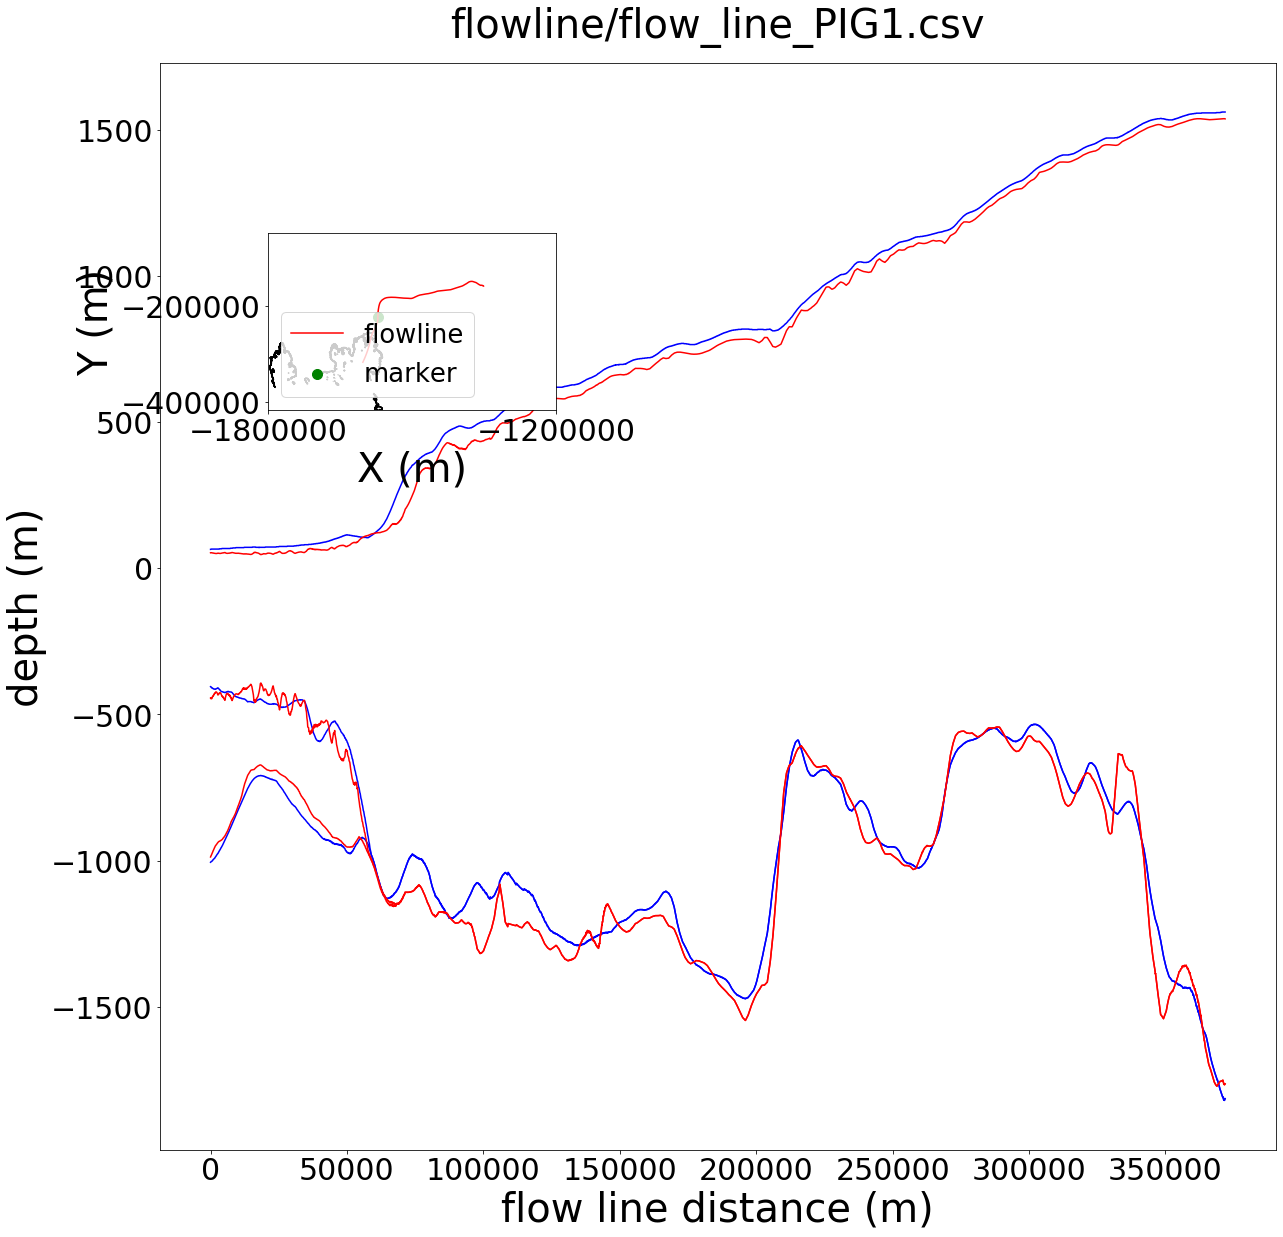

4999


8981


10002


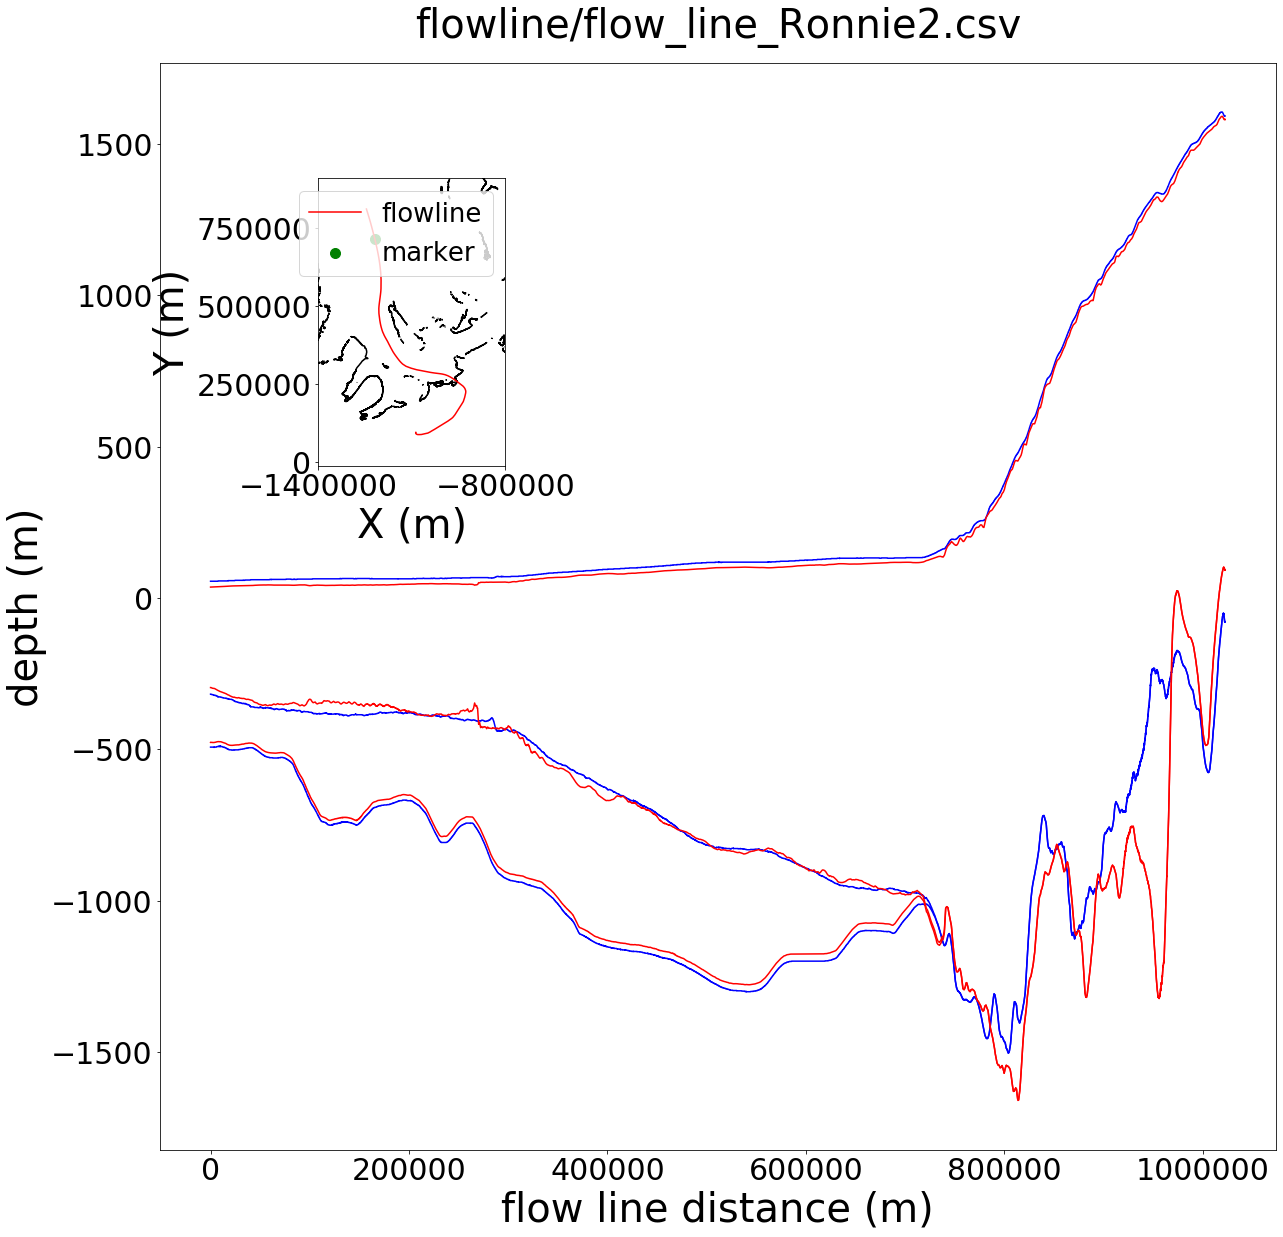

10002


10002


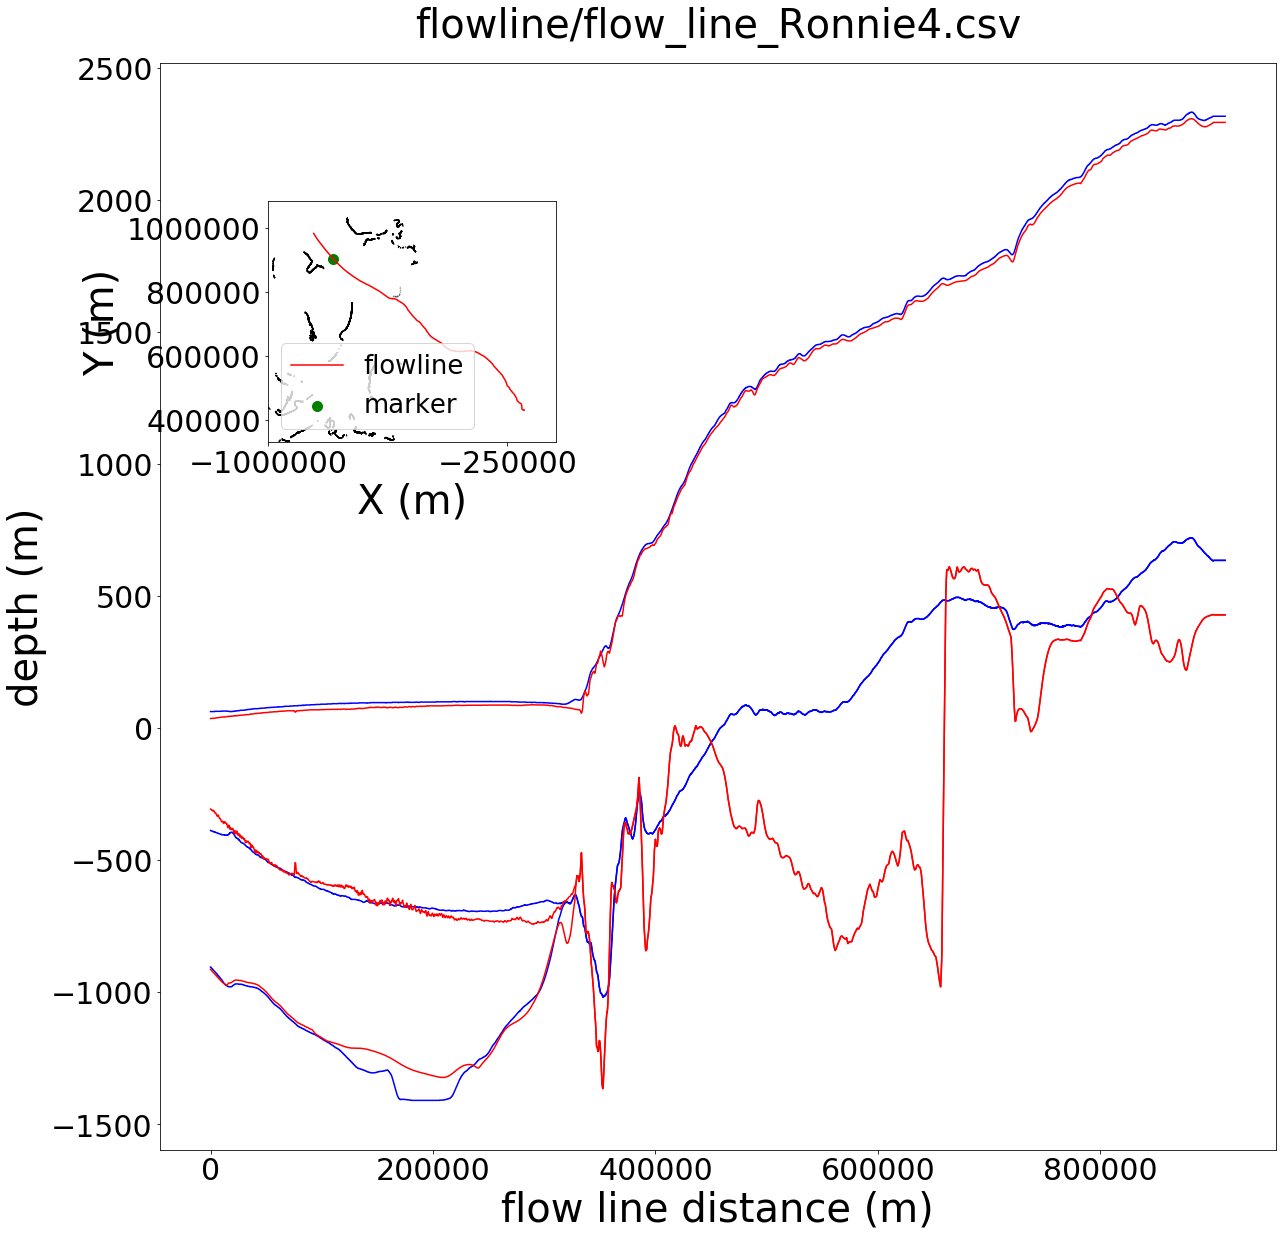

10002


4439


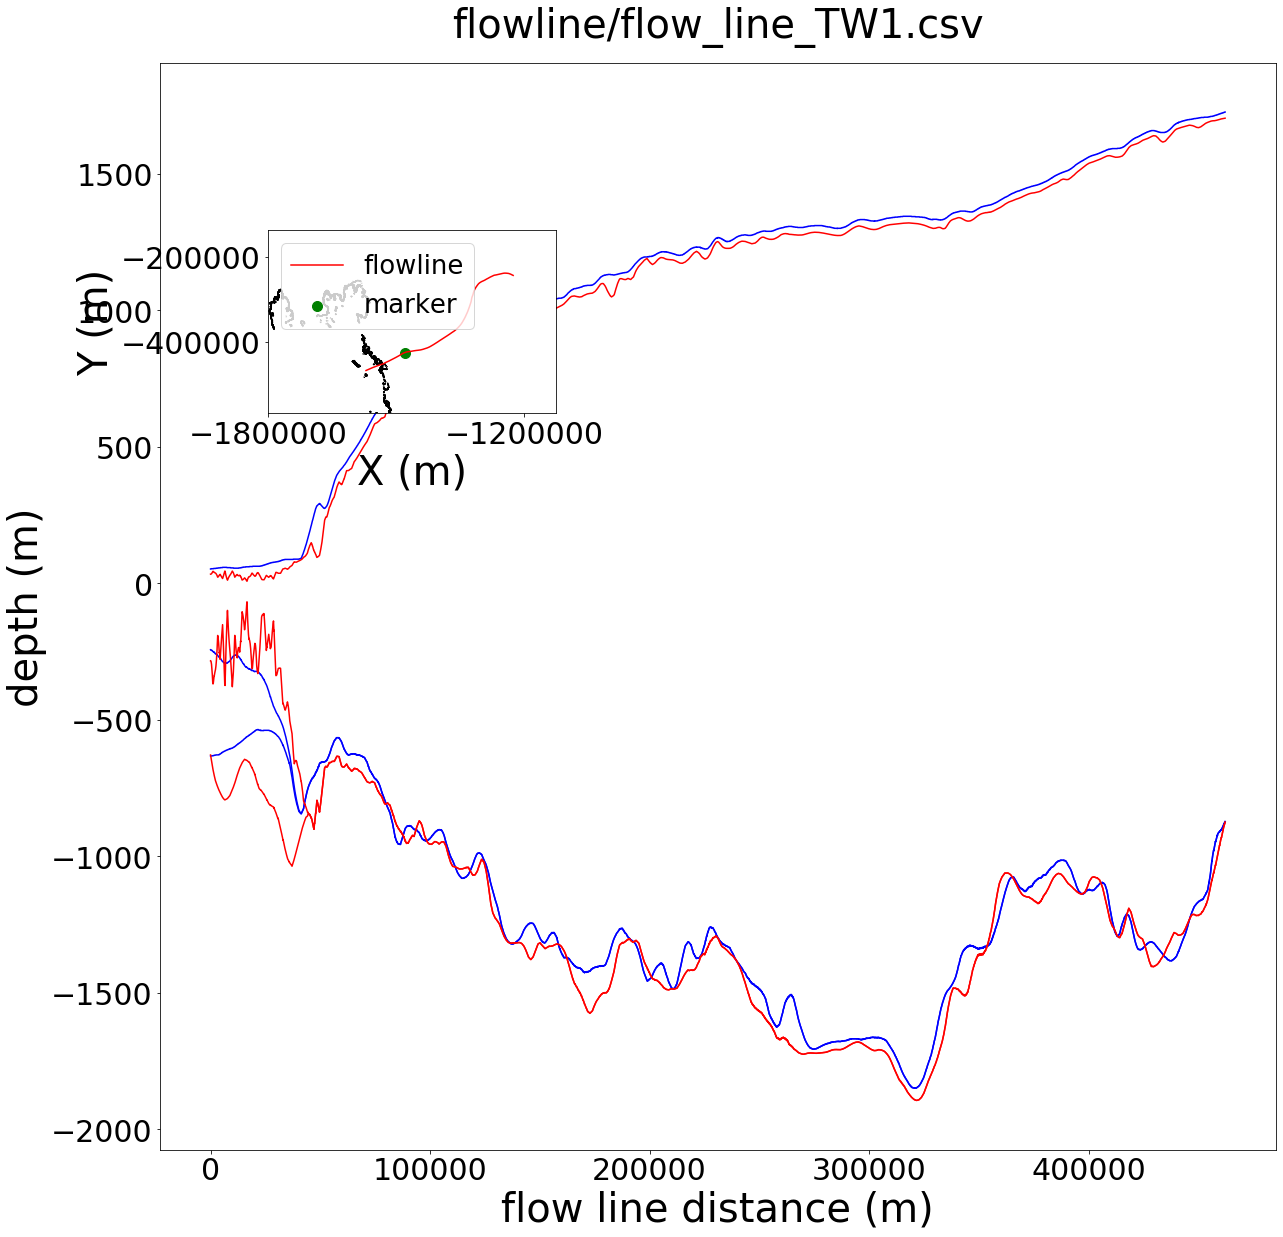

3017


In [8]:
flowlines=np.sort(glob.glob('/home/urrutyb/Documents/PhD_TiPACCS/data_antarctica/flowline/flow_line*.csv'))
for name in flowlines:
    flowline=name[:-4]
    x_fl,y_fl,f1,f2,length=line_flow(flowline,x,y,bedmap_bed,bedmachinebed)
    x_fl,y_fl,t1,t2,length=line_flow(flowline,x,y,bedmap_th,bedmachineth)
    x_fl,y_fl,s1,s2,length=line_flow(flowline,x,y,bedmap_surf,bedmachinesurf)
    z1=s1-t1
    z2=s2-t2
    print(len(length))
   ###
#     delta_x=x_fl[:-1]-x_fl[1:];
#     delta_y=y_fl[:-1]-y_fl[1:];
#     norm=np.sqrt(delta_x**2+delta_y**2);
#     length=np.zeros(len(x_fl));
#     for i in range(0,len(delta_x)):
#         length[i+1]=length[i]+norm[i];
#     del delta_x,delta_y,norm
    ###
    fig=plt.figure(figsize=[20,20])
    plt.rcParams.update({'font.size': 15})
    ax=fig.add_subplot(111)
    ax.plot(length,f1,c='b',label='bed bedmap')
    ax.plot(length,z1,c='b',label='z_b bedmap')
    ax.plot(length,s1,c='b',label='surface bedmap')
#     ax.axvline(length[1000], ymin=-2000, ymax=3000,c='g',label='marker line')
    ax.plot(length,f2,c='r',label='bed bedmachine')
    ax.plot(length,z2,c='r',label=' z_b bedmachine')
    ax.plot(length,s2,c='r',label='surface bedmachine')
#     ax.legend()
    ax.set_xlabel('flow line distance (m)')
    ax.set_ylabel('depth (m)')
    plt.title(name[52:])
    ax2=fig.add_subplot(position=[0.2, 0.6, 0.2, 0.2])
    sf.plot(ax=ax2, color='k')
#     im=ax2.pcolormesh(x,y,bedmachinebed,cmap=cm.seismic)
    ax2.plot(x_fl,y_fl,c='r',label='flowline')
    ax2.scatter(x_fl[1000],y_fl[1000],s=100,c='g',label='marker')
    ax2.set_xlim(x_fl.min()-100000,x_fl.max()+100000)
    ax2.set_ylim(y_fl.min()-100000,y_fl.max()+100000)
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
#     divider = make_axes_locatable(ax2)
#     cax = divider.append_axes("right", size="5%", pad=0.1)
#     cbar=plt.colorbar(im,cax=cax)
#     cbar.set_label('bedmachine depth of the bed (m)')
    ax2.legend()
    v1=ax2.get_xticks()
    ax2.set_xticks(v1[::3])
    fig.savefig('/home/urrutyb/Documents/PhD_TiPACCS/data_antarctica/flowline/dem'+ flowline[61:] + '.pdf')
    plt.show()


In [9]:
len(length)

3017

Bedmachine seems to have more rugosity than bedmap2.

We observed a wierd square near vostok lake. When we look precisely at it, this seems to come from radar data

In [10]:
# #carré
# carre=[800000, 1400000, -900000, -300000]
# x_carre,y_carre,z_bedmap=selectarea(carre,x,y,bedmap_bed)
# x_Amundsen,y_Amundsen,z_bedmachine=selectarea(carre,x,y,bedmachinebed)
# x_Amundsen,y_Amundsen,z_bed=selectarea(carre,x,y,test)
# fig=plt.figure(figsize=[20,12])
# plt.rcParams.update({'font.size': 15})
# ax1=plt.subplot(221)
# im=ax1.pcolormesh(x_carre,y_carre,z_bed,norm=SymLogNorm(linthresh=10, linscale=0.1 , vmin=z_bed.min(), vmax=z_bed.max()),cmap=cm.seismic)
# cbar=plt.colorbar(im, ax=ax1)
# cbar.set_label('difference bedmap-bedmachine (m)')
# ax1.set_xlim(x_carre.min(),x_carre.max())
# ax1.set_ylim(y_carre.min(),y_carre.max())
# ax1.set_title('difference')
# ax2=plt.subplot(222)
# im=ax2.pcolormesh(x_carre,y_carre,z_bedmap,cmap=cm.seismic) #,norm=SymLogNorm(linthresh=10, linscale=0.1 , vmin=z_bedmap.min(), vmax=z_bedmap.max()),cmap=cm.seismic)
# ax2.set_xlim(x_carre.min(),x_carre.max())
# ax2.set_ylim(y_carre.min(),y_carre.max())
# cbar=plt.colorbar(im, ax=ax2)
# cbar.set_label('depth of the bed (m)')
# ax2.set_title('bedmap')
# ax3=plt.subplot(223)
# im=ax3.pcolormesh(x_carre,y_carre,z_bedmachine,cmap=cm.seismic) #,norm=SymLogNorm(linthresh=10, linscale=0.1 , vmin=z_bedmap.min(), vmax=z_bedmap.max()),cmap=cm.seismic)
# ax3.set_xlim(x_carre.min(),x_carre.max())
# ax3.set_ylim(y_carre.min(),y_carre.max())
# ax3.set_title('bedmachine')
# cbar=plt.colorbar(im, ax=ax3)
# cbar.set_label('depth of the bed (m)')
# fig.suptitle('le carré???')
# plt.show()
# #fig.savefig('carre.png')
# #plt.close()

## Shelf extension

We compare the area of the ice-self because the two beds are using different data and the extent of the self should differed.
Teh yellow area is the ice-shelf surface loss between bedmap2 and bedmachine. There is 42686 points which differ from one bed to the other. Because the mesh is define by a regular grid of 1km, we understood this as 42686 $km^2$ difference of shelf extension. Which represent a difference of 0.3%.

In [11]:
bedmap_mask=np.flip(np.loadtxt('/home/urrutyb/Documents/PhD_TiPACCS/data_antarctica/bedmap2_ascii/bedmap2_icemask_grounded_and_shelves.txt',skiprows=6),0)

In [29]:
values=(bedmachinemask==3)
diff=bedmap_mask-values
ocean=(diff==-9999)
grounded=(diff==-1)
lost=(diff==1)
win=(diff==-10000)


<xarray.DataArray 'mask' (y: 6667, x: 6667)>
array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])
Coordinates:
  * x        (x) int32 -3333000 -3332000 -3331000 ... 3331000 3332000 3333000
  * y        (y) int32 -3333000 -3332000 -3331000 ... 3331000 3332000 3333000

In [ ]:
plt.figure(figsize=[20,20])
ax=plt.gca()
ax.pcolormesh(x,y,lost)
area=np.array(sum(sum(bedmap_mask!=-9999)))
area_lost=np.array(sum(sum(lost)))
sf.plot(ax=ax)
plt.title('iceshelf surface lost in ocean = ' +str(area_lost) + ' points pourcent = ' + str(area_lost/area*100) + ' %')
plt.figure(figsize=[20,20])
ax=plt.gca()
ax.pcolormesh(x,y,grounded)
# sf.plot(ax=ax)
area_win=np.array(sum(sum(grounded)))
plt.title('iceshelf surface win from grouded = ' +str(area_win) + ' points pourcent = ' + str(area_win/area*100) + ' %')
plt.figure(figsize=[20,20])
ax=plt.gca()
ax.pcolormesh(x,y,win)
sf.plot(ax=ax)
area_win=np.array(sum(sum(win)))
plt.title('iceshelf surface win from ocean = ' +str(area_win) + ' points pourcent = ' + str(area_win/area*100) + ' %')


In [ ]:
plt.figure(figsize=[20,20])
ax=plt.gca()
ax.pcolormesh(x,y,diff,clim=[-1,2])